In [1]:
from dichasus_cf0x import training_set
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tqdm

2023-10-18 17:08:30.280967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-18 17:08:31.065512: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-18 17:08:31.919891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-18 17:08:31.941286: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
def csi_time_domain(csi, pos, time):
    csi = tf.signal.fftshift(tf.signal.ifft(tf.signal.fftshift(csi, axes = -1)), axes=-1)

    return csi, pos, time

def cut_out_taps(tap_start, tap_stop):
    def cut_out_taps_func(csi, pos, time):
        return csi[:,:,:,tap_start:tap_stop], pos, time

    return cut_out_taps_func

training_set = training_set.map(csi_time_domain, num_parallel_calls = tf.data.AUTOTUNE)
training_set = training_set.map(cut_out_taps(512-8, 512+40), num_parallel_calls = tf.data.AUTOTUNE)

In [3]:
BANDWIDTH = 50e6

def csi_to_delayspreads(csi, pos, time):
    # csi comes in as shape (arrays, rows, columns, subcarriers)
    # --> we want (arrays, antennas = rows * columns, subcarriers), reshape!
    csi_by_array = tf.reshape(csi, (tf.shape(csi)[0], 8, tf.shape(csi)[3]))
    print(csi_by_array)
    powers = tf.square(tf.abs(csi_by_array))
    timestamps = tf.range(tf.shape(csi_by_array)[2], dtype = np.float32) / BANDWIDTH
    time_weighted_powers = tf.einsum("amt,t->amt", powers, timestamps)
    mean_delays = tf.divide(tf.reduce_sum(time_weighted_powers, axis = 2), tf.reduce_sum(powers, axis = 2))
    squared_delays = tf.square(timestamps[tf.newaxis, tf.newaxis, :] - mean_delays[:, :, tf.newaxis])
    delayspreads = tf.sqrt(tf.divide(tf.reduce_sum(tf.multiply(squared_delays, powers), axis = 2), tf.reduce_sum(powers, axis = 2)))

    return csi, delayspreads, pos, time

In [4]:
training_set_with_ds = training_set.map(csi_to_delayspreads, num_parallel_calls = tf.data.AUTOTUNE)

Tensor("Reshape:0", shape=(4, 8, 48), dtype=complex64)


In [5]:
groundtruth_positions = []
delayspreads = []

for csi, ds, pos, time in training_set_with_ds.batch(1000):
    groundtruth_positions.append(pos.numpy())
    delayspreads.append(ds.numpy())

groundtruth_positions = np.concatenate(groundtruth_positions)
delayspreads = np.concatenate(delayspreads)

In [6]:
delayspreads_by_array = np.mean(delayspreads, axis = -1)
np.save("results/delayspreads.npy", delayspreads_by_array)

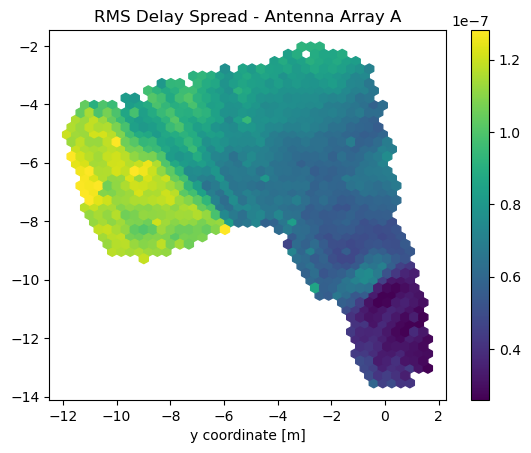

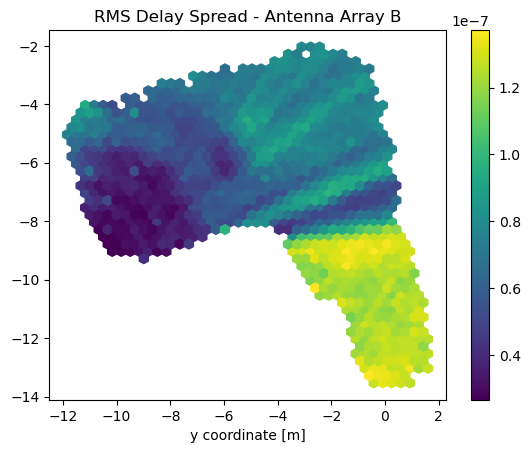

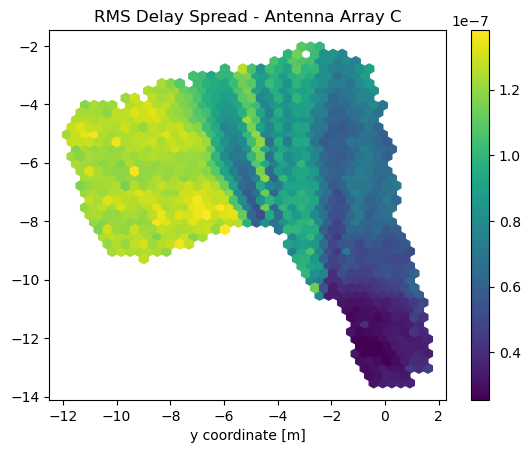

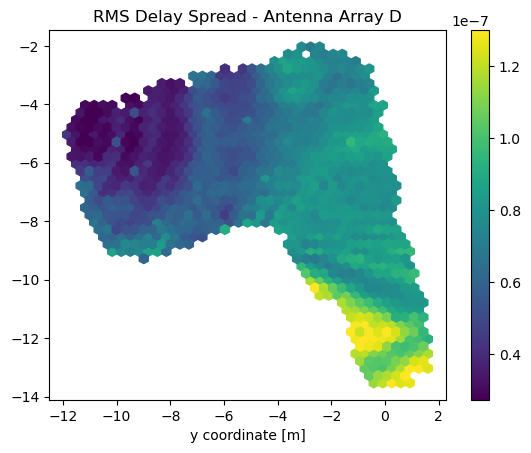

In [7]:
for array in range(np.shape(delayspreads_by_array)[1]):
    ds = delayspreads_by_array[:, array]
    vmin = np.quantile(ds, 0.01)
    vmax = np.quantile(ds, 0.99)
    plt.title("RMS Delay Spread - Antenna Array " + chr(ord("A") + array))
    plt.xlabel("x coordinate [m]")
    plt.xlabel("y coordinate [m]")
    plt.hexbin(groundtruth_positions[:, 0], groundtruth_positions[:, 1], gridsize = 40, C = ds, vmin = vmin, vmax = vmax)
    plt.colorbar()
    plt.show()